## Laboratorio 4 - Clasificación de malware
Diana Ximena de León Figueroa 18607 \
Paula Camila González Ortega 18398

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import pickle as pickle
import joblib
from collections import Counter
import tensorflow as tf

import random
random.seed(42)

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import metrics, model_selection, tree
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### Exploración

In [2]:
df = pd.read_csv("VirusSample.csv")

In [3]:
df.head()

,file,api,class
0,7ff49f2f0912352416b05c010f35f402cc79feed,"IntersectRect,GetCurrentProcess,GetVersion",Virus
1,50cc6c99ec285d0db45dde07d8fdc18d9098c5b6,"GetCaretBlinkTime,CountClipboardFormats,GetCon...",Virus
2,f77c6bd4aebacd1a01d02e0cb20642ebf2d32929,"VarR8Pow,GetClipboardViewer,GetInputDesktop,Ge...",Virus
3,349c367c5b88fbb6cafae5d7109588d7250e16b5,"SetTraceCallback,CopyAcceleratorTableW,GetProc...",Virus
4,021f4aa86b520e1d606ab26699c35546bcd00c27,"SHLoadNonloadedIconOverlayIdentifiers,VarUI8Fr...",Virus


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9795 entries, 0 to 9794
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    9795 non-null   object
 1   api     9795 non-null   object
 2   class   9795 non-null   object
dtypes: object(3)
memory usage: 229.7+ KB


In [5]:
df['class'].value_counts()

Trojan        6153
Virus         2367
Backdoor       447
Worms          441
Adware         222
Agent          102
Downloader      31
Spyware         11
Ransomware      10
Riskware         4
Dropper          4
Crypt            2
Keylogger        1
Name: class, dtype: int64

In [6]:
# Los tipos de virus se pasan como numeros para poder manejarlos en los modelos
df['class'] = df['class'].replace(['Trojan', 'Virus', 'Backdoor', 'Worms','Adware', 'Agent', 
                                   'Downloader', 'Spyware', 'Ransomware', 'Riskware', 'Dropper', 'Crypt', 'Keylogger'],
                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [7]:
df['class'].value_counts()

0     6153
1     2367
2      447
3      441
4      222
5      102
6       31
7       11
8       10
9        4
10       4
11       2
12       1
Name: class, dtype: int64

In [8]:
df['class'] = df['class'].astype('category')

#Label Encoder para dar valores int a las API Calls de cada linea
le = preprocessing.LabelEncoder()
dataset_X = df.values[:,0:2]
dataset_X

dataset_X_pandas = pd.DataFrame(dataset_X,dtype=str)
dataset_X_pandas.apply(le.fit_transform)

dataset_X = dataset_X_pandas.apply(le.fit_transform).values[:,:]
dataset_X 

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in range(2):
    df.values[:,i] = le.fit_transform(df.values[:,i])

In [10]:
def convert(data):
    number = preprocessing.LabelEncoder()
    data['file'] = number.fit_transform(data.file)
    data['api'] = number.fit_transform(data.api)
    #data=data.fillna(-999)
    return data

df=convert(df)
#test=convert(test)

In [11]:
df

,file,api,class
0,4922,1255,1
1,3128,605,1
2,9476,2531,1
3,2046,2271,1
4,83,2151,1
...,...,...,...
9790,2264,1631,0
9791,3259,2083,0
9792,8448,2743,0
9793,7917,1222,0


### Preprocesamiento

In [12]:
samples = []
df = sklearn.utils.shuffle(df)
df_split = np.array_split(df, 10)

for chunk in df_split:
    # chunk = chunk.sample(frac =.12, random_state = 33, replace=True)
    chunk = chunk.sample(frac =.15, random_state = 33, replace=True)
        
    samples.append(chunk)

In [13]:
df_sample = pd.concat(samples)

In [14]:
X = df_sample.drop(['class'], axis=1)
y = df_sample['class']

In [15]:
X

,file,api
6956,3101,1486
5855,5886,1325
9294,2727,2377
5981,7424,2611
2334,7411,2486
...,...,...
8168,4677,2846
5639,6007,2846
9474,640,1747
1494,9079,925


In [16]:
y

6956    0
5855    0
9294    3
5981    0
2334    1
       ..
8168    0
5639    0
9474    1
1494    0
7426    0
Name: class, Length: 1470, dtype: category
Categories (13, int64): [0, 1, 2, 3, ..., 9, 10, 11, 12]

In [17]:
rus = RandomUnderSampler(random_state=10, replacement=True)# fit predictor and target variable

In [18]:
X_balanced, y_balanced = rus.fit_resample(X, y)

In [19]:
print('Original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_balanced))

Original dataset shape: Counter({0: 942, 1: 332, 2: 72, 3: 64, 4: 34, 5: 18, 6: 3, 7: 2, 8: 2, 9: 1})
Resample dataset shape Counter({0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1})


### Divison de data

In [39]:
#Split de train y test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
print(X_train.shape, y_train.shape)

(1029, 2) (1029,)


In [41]:
print(X_test.shape, y_test.shape)

(441, 2) (441,)


### Escalamiento de datos

In [42]:
#scaler = MinMaxScaler()
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

In [45]:
sc.fit(x_train.reshape(-1,1),y_train)
sc.fit(x_test.reshape(-1,1),y_test)
#X_train = scaler.fit_transform(X_train)

StandardScaler()

In [50]:
X_test = scaler.transform(X_test)
X_test.shape

(441, 2)

In [54]:
y_test.shape

(441,)

In [51]:
X_train.shape

(1029, 2)

In [53]:
y_train.shape

(1029,)

In [158]:
#pd.DataFrame(X_train).to_csv('x_train_scaled.csv', index = False)
#pd.DataFrame(y_train).to_csv('y_train_scaled.csv', index = False)

In [159]:
#pd.DataFrame(X_test).to_csv('x_test_scaled.csv', index = False)
#pd.DataFrame(y_test).to_csv('y_test_scaled.csv', index = False)

In [160]:
#joblib.dump(scaler,'escalador.pkl')

['escalador.pkl']

## Modelos de clasificación

### K Neighbors

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
print('{} nn değeri için {} '.format(3,knn.score(x_test,y_test)))

ValueError: Found input variables with inconsistent numbers of samples: [441, 103]

### Naive Bayes Gaussiano

In [161]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train, y_train.astype('int'))

GaussianNB()

In [162]:
acc_train= clf.score(X_train, y_train.astype('int'))
print("Accuracy de training: %f %%" % (acc_train*100))

Accuracy de training: 62.001944 %


In [163]:
acc_test = clf.score(X_test, y_test.astype('int'))
print("Accuracy de testing: %f %%" % (acc_test*100))

Accuracy de testing: 61.904762 %


In [164]:
Y_pred = clf.predict(X_test)
Y_pred = Y_pred.astype(str)
target_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print(classification_report(Y_test, Y_pred, target_names=target_names))

ValueError: Mix of label input types (string and number)

## Gradient Boosting

In [25]:
from sklearn import metrics, model_selection, tree
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=7)

In [26]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=7)

In [27]:
## Test data
clf.score(X_test, y_test)

0.0022675736961451248

In [28]:
pred = clf.predict(X_test)

In [31]:
print(metrics.accuracy_score(y_test, pred))
print('Matriz de confusion', metrics.confusion_matrix(y_test, pred))
print(metrics.classification_report(y_test, pred, target_names=['0', '1', '2', '3', '4', '5', '6', '7']))

0.0022675736961451248
Matriz de confusion [[  0   0   0   0   0   0   0 276]
 [  0   0   0   0   0   0   0 119]
 [  0   0   0   0   0   0   0  14]
 [  0   0   0   0   0   0   0  17]
 [  0   0   0   0   0   0   0   7]
 [  0   0   0   0   0   0   0   6]
 [  0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       276
           1       0.00      0.00      0.00       119
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         1
           7       0.00      1.00      0.00         1

    accuracy                           0.00       441
   macro avg       0.00      0.12      0.00       441
weighted avg       0.00      0.00      0.00       441



c:\users\camila\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\camila\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\camila\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [176]:
# Extraido de: https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

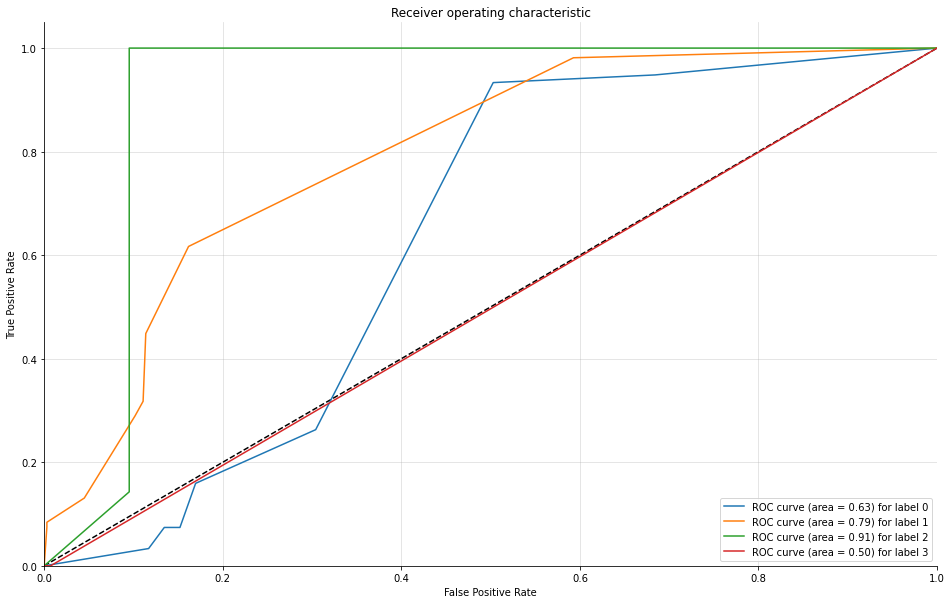

In [177]:
plot_multiclass_roc(clf, X_test, y_test, n_classes=4, figsize=(16, 10))

In [32]:
rf_cv_score=cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(rf_cv_score)

c:\users\camila\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


[0.69902913 0.69902913 0.67961165 0.73786408 0.78640777 0.
 0.77669903 0.65048544 0.72815534 0.76470588]


In [34]:
from sklearn.model_selection import KFold
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [35]:
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.705 (0.078)


In [38]:
from sklearn.model_selection import RepeatedKFold
kf = KFold(n_splits=10)
for train, test in kf.split(X_train):
    print("%s %s" % (train, test))

[ 103  104  105  106  107  108  109  110  111  112  113  114  115  116
  117  118  119  120  121  122  123  124  125  126  127  128  129  130
  131  132  133  134  135  136  137  138  139  140  141  142  143  144
  145  146  147  148  149  150  151  152  153  154  155  156  157  158
  159  160  161  162  163  164  165  166  167  168  169  170  171  172
  173  174  175  176  177  178  179  180  181  182  183  184  185  186
  187  188  189  190  191  192  193  194  195  196  197  198  199  200
  201  202  203  204  205  206  207  208  209  210  211  212  213  214
  215  216  217  218  219  220  221  222  223  224  225  226  227  228
  229  230  231  232  233  234  235  236  237  238  239  240  241  242
  243  244  245  246  247  248  249  250  251  252  253  254  255  256
  257  258  259  260  261  262  263  264  265  266  267  268  269  270
  271  272  273  274  275  276  277  278  279  280  281  282  283  284
  285  286  287  288  289  290  291  292  293  294  295  296  297  298
  299 